agent : start  [0, 0]  agent goal  [2, 4]
memory usage  88793088
 peak m usage  86712
total time  0.049516916275024414
------------- ROBOT SIMULATED PATH BFS ------------------ 
VISITED POSITIONS  18
[[0, 0], [0, 1], [0, 2], [0, 3], [1, 3], [2, 3], [2, 4]]
path cost  7


<Figure size 432x288 with 0 Axes>

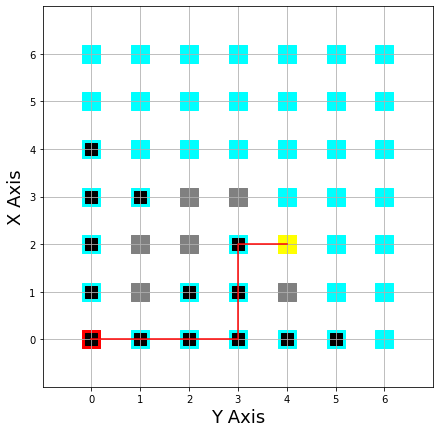

In [1]:
import queue
from typing import *
import typing
import numpy
import agent
import copy

from matplotlib import pyplot as plt
import os, psutil
import resource #erase
import time

import environment 


class Breath_First_Search():
    
    ###
    # find coordinate of a tile given its hash
    # 
    # input: 
    #   env: numpy matrix of 8 digit hash values
    #   hash_value: 8 digit hash of str(coordinate of tile)
    # output:
    #   [x,y] coordinates
    # 
    # ###    
    def find_tile_by_hash(self, env: environment.Environment, hash_value: int):
        x_coord, y_coord = numpy.where(env.get_environment_hash_matrix()[:,:] == hash_value)
        return [x_coord[0], y_coord[0]]


    ###
    # find list tiles accessible from current position (not obstacles)
    # update agent's moves possibilities
    # input:
    #       node_list_coord_hash: 8 digit hash of str(coordinate of tile)  
    #       env: numpy matrix of 8 digit hash values 
    #       closed_set: seen nodes
    #       agent: current agent   
    # output:
    #       children_list: list of 8 digit hash values accessible from current position
    #       agent: updated agent
    ####
    def generate_children_list(self, node_list_coord_hash: int, env: environment.Environment, closed_set: List[int],  agent: agent.Agent):
        current_node_coord_list = self.find_tile_by_hash(env, node_list_coord_hash)
        node_x_axis = current_node_coord_list[0] 
        node_y_axis = current_node_coord_list[1]
        children_list = []
        moves_list = []#empty list

        ###### UPDATE AGENT MOVES POSSIBLITIES  
        #can agent go up ?
        if node_x_axis-1 >= 0:
            child_hash = env.get_environment_hash_matrix()[node_x_axis-1, node_y_axis]

            tile_is_obstacle = env.get_environment_matrix()[node_x_axis-1, node_y_axis]
            if(tile_is_obstacle == 0) and child_hash not in closed_set :#if tile is not obstacle
                children_list.append(child_hash)
                moves_list.append("U")
            pass

        # can agent go right ?
        if node_y_axis+1 < env.get_matrix_dimension()[1]:
            child_hash = env.get_environment_hash_matrix()[ node_x_axis, node_y_axis+1] 
            tile_is_obstacle = env.get_environment_matrix()[node_x_axis, node_y_axis+1]
            if(tile_is_obstacle == 0)  and child_hash not in closed_set:#if tile is not obstacle
                children_list.append(child_hash)
                moves_list.append("R")
            pass   

        # can agent go down ?
        if node_x_axis+1 < env.get_matrix_dimension()[0]: 
            child_hash = env.get_environment_hash_matrix()[node_x_axis+1, node_y_axis]
            tile_is_obstacle = env.get_environment_matrix()[node_x_axis+1, node_y_axis]

            if(tile_is_obstacle == 0) and child_hash not in closed_set:#if tile is not obstacle
                children_list.append(child_hash)
                moves_list.append("D")
            pass
        
            # can agent go left ?
        if node_y_axis-1 >= 0:
            child_hash = env.get_environment_hash_matrix()[ node_x_axis, node_y_axis-1] 
            tile_is_obstacle = env.get_environment_matrix()[node_x_axis, node_y_axis-1]
            if(tile_is_obstacle == 0) and child_hash not in closed_set:#if tile is not obstacle
                children_list.append(child_hash)
                moves_list.append("L")
            pass

        #reset agent move set
        agent.moves_list = moves_list # must return 

        return (children_list, agent)


    ###
    # find goal tile
    # 
    # input:
    #       initial_state: 8 digit float of start state coord str([x,y])  
    #       goal_state: 8 digit float of goal state coord str([x,y])
    #       my_plt: plot obj
    #  output: 
    #       parent: goal node ((cost, g+h), (hash_of_node, hash_of_parent))
    #       edges_dict: all node ever placed in priority queue
    # ###
    def fetch_Goal_Node(self, 
    intial_state: int, goal_state: int, queue_size, env_matrix, agent: agent.Agent, my_plt):

        init_s_node_hash = intial_state
        goal_state_hash = goal_state
        edges_dict = {}

        if init_s_node_hash == goal_state_hash:
            return (init_s_node_hash, edges_dict)

        open_set = queue.Queue(queue_size)#unexplored nodes (contains only hashes)
        open_set.put(init_s_node_hash)#populate first node
        
        open_set_list = []
        open_set_list.append(init_s_node_hash)

        closed_set = []

        while not open_set.empty():

            parent = open_set.get()#pop stack FIFO 

            open_set_list.remove(parent)

            closed_set.append(parent)#and appends to seen nodes
            children_hash_list = self.generate_children_list(parent, env_matrix, closed_set , agent)[0]
            parent_coord = self.find_tile_by_hash(env_matrix, parent)
            my_plt.scatter(parent_coord[1], parent_coord[0], s=150, c='black', marker='s')

            for child_hash in children_hash_list:

                v = child_hash ##hash (state coorinate)
                #print("currernt exploration ",v)
                if (v not in closed_set) and (child_hash not in open_set_list):
                    edges_dict[child_hash] = parent #keep track of edges connections
                    if v == goal_state_hash:
                        return (child_hash, edges_dict)
                    
                    open_set.put(child_hash)##add on stack 
                    open_set_list.append(child_hash)         

        return (0, edges_dict) #failed

    ###
    # reconstruct path from goal to answer by taking 
    # 
    # input:
    #       ancestors_dict 
    #       start_hash, 
    #       goal_hash, 
    #       env: environment.Environment, 
    # output:
    #       array path
    # ### 
    def reconstruct_path(self, ancestors_dict, start_hash, goal_hash, env: environment.Environment):
        coord = self.find_tile_by_hash(env, goal_hash)
        current_key = goal_hash
        path_array = []
        path_array.append(coord)
        print("VISITED POSITIONS ", len(ancestors_dict[1]))
        if(ancestors_dict[0]!= 0):#only reconstruct if we have found a path
            while current_key != start_hash:
                new_key = ancestors_dict[1][current_key]
                coord = self.find_tile_by_hash(env, new_key) 
                path_array.append(coord)
                current_key = new_key
        else:
            print("ancestry cannot be reached ")

        return path_array[::-1]
    
    def return_cost(self, path: List[int], agent: agent.Agent):
        return len(path)*agent.get_motion_cost()[0]

start_time = time.time()
env = environment.Environment(7,7, [[1,1], [2,1], [2, 2],[3,2], [3,3], [1,4]])

BFS = Breath_First_Search()

agent = agent.Agent([0,0], [2,4], [1,1,1,1])
my_plt = env.draw_map(agent)

print("agent : start ", agent.initial_state, " agent goal ", agent.goal_state)

mat_size = env.get_matrix_dimension()[0]*env.get_matrix_dimension()[1]
goal = BFS.fetch_Goal_Node(agent.get_initial_state_hash(), agent.get_goal_state_hash(), mat_size, env, agent, my_plt)

process = psutil.Process(os.getpid())
print("memory usage ",process.memory_info().rss)  # in bytes 
print(" peak m usage ", resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)
print("total time ", time.time() - start_time)

print("------------- ROBOT SIMULATED PATH BFS ------------------ ")
path = BFS.reconstruct_path(goal, agent.get_initial_state_hash(), agent.get_goal_state_hash(), env)
print(path)
print("path cost ", BFS.return_cost(path, agent))


x = [x[0] for x in  path]
y = [x[1] for x in  path]
my_plt.plot(y, x, linestyle='solid', c='red')